# Data Description
#### gender_age_train.csv, gender_age_test.csv 
group: this is the target variable you are going to predict
#### phone_brand_device_model.csv 
device ids, brand, and models
#### events.csv, app_events.csv  
When a user uses TalkingData SDK, the event gets logged in this data. <br>
Each event has an event id, location (lat/long), time, and the event corresponds to a list of apps in app_events.<br>
#### app_labels.csv 
apps and their labels, the label_id's can be used to join with label_categories
#### label_categories.csv 
apps' labels and their categories in text

# Table of Content <a class="anchor" id="content"></a>
## [1.EDA](#EDA)
>  
### [1.1 Map](#map)
### [1.2 Phone Brand](#phone-brand) 
### [1.3 Phone Brand](#phone-model)
### [1.4 APP ID](#app-id) 
### [1.5 APP Label](#app-label) 
### [1.6 Event Trigger Time](#event-time) 

    
## [2.Modeling](#model) 
>> 
2.0.1 Split into train and test(validation) in stratified way <br>
2.0.2 Prepare a cross validation function to calculate log loss for each model <br> 
> 
### [2.1 Logistic Regression](#logistic)
>> 
2.1.1 Find optimal C (smaller values specify stronger regularization) and solver <br>
2.1.2 Cross validation <br>
2.1.3 Final Result 
>
### [2.2 XGBoost](#xgboost)
>> 
2.2.1 Grid search to find optimal hyper parameters <br>
2.2.2 Find optimal num of boosting round <br>
2.2.3 Cross validation <br>
2.2.4 Final Result
> 
### [2.3 Random Forest](#randomforest)
>> 
2.3.1 Grid search to find optimal hyper parameters <br>
2.3.2 Cross validation <br>
2.3.3 Final Result
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.basemap import Basemap
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

In [2]:
train = pd.read_csv('../input/gender_age_train.csv',index_col='device_id')
test = pd.read_csv('../input/gender_age_test.csv',index_col='device_id')
phone = pd.read_csv('../input/phone_brand_device_model.csv',encoding='utf-8')
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id') #drop duplicate phone
events = pd.read_csv('../input/events.csv', parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv('../input/app_events.csv', usecols=['event_id','app_id','is_active'], dtype={'is_active':bool})
applabels = pd.read_csv('../input/app_labels.csv') #one app can have multiple labels
labelcat = pd.read_csv('../input/label_categories.csv')

C:\Users\yiqin\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
train.head(3)
phone.head(3)
events.head(3)
appevents.head(3)
applabels.head(3)
labelcat.head(3)

,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38


,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4


,device_id,timestamp,longitude,latitude
event_id,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70


,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406


,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes


# 1. EDA  <a class="anchor" id='EDA'></a>    
[back to content](#content)

In [4]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack

In [5]:
train['trainrow'] = np.arange(train.shape[0])
test['testrow'] = np.arange(test.shape[0])

## 1.1 map <a class="anchor" id='map'></a>
[back to content](#content)

In [55]:
event_join = events.merge(train,left_on="device_id", right_index=True)
event_join.head()

,device_id,timestamp,longitude,latitude,hour,hour2,wkend,gender,age,group,trainrow
event_id,,,,,,,,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,0,midnight,1,M,46,M39+,58469
7104,29182687948017175,2016-05-02 09:37:02,121.38,31.24,9,daytime,0,M,46,M39+,58469
29661,29182687948017175,2016-05-04 00:56:04,121.39,31.23,0,midnight,0,M,46,M39+,58469
33133,29182687948017175,2016-05-06 05:01:15,121.38,31.24,5,early morning,0,M,46,M39+,58469
38980,29182687948017175,2016-05-06 09:55:04,121.16,31.00,9,daytime,0,M,46,M39+,58469


In [66]:
np.sqrt(event_join.age.values/50)

array([0.9591663 , 0.9591663 , 0.9591663 , ..., 0.98994949, 0.72111026,
       0.63245553])

In [62]:
np.random.seed(19680801)


x = np.random.rand(10)
y = np.random.rand(10)
z = np.sqrt(x**2 + y**2)
z

array([0.74628852, 0.81751634, 1.20065663, 0.89640426, 1.08331782,
       0.99642089, 0.56867126, 0.94206565, 1.01687848, 0.95171842])

TypeError: object of type 'float' has no len()

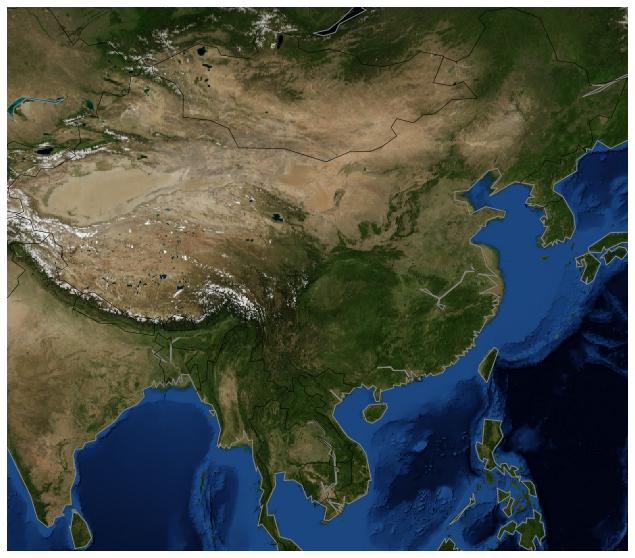

In [68]:
fig = plt.figure(figsize=(16, 10))
m = Basemap(
    projection='mill', lon_0=104.166, lat_0=36.894402,
    llcrnrlon=73.557701, llcrnrlat=5.77539,
    urcrnrlon=134.773605, urcrnrlat=53.5606)
m.bluemarble()
m.drawcoastlines(color = 'gray')
m.drawcountries(color = 'black')
x, y = m(event_join.longitude.values, event_join.latitude.values)
c = 0.9899
m.scatter(x, y, s=1, marker= ',', c = c)

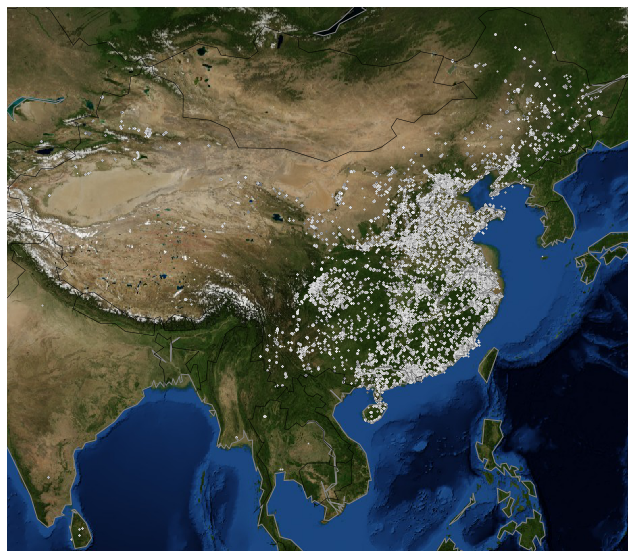

In [67]:
fig = plt.figure(figsize=(16, 10))
m = Basemap(
    projection='mill', lon_0=104.166, lat_0=36.894402,
    llcrnrlon=73.557701, llcrnrlat=5.77539,
    urcrnrlon=134.773605, urcrnrlat=53.5606)
m.bluemarble()
m.drawcoastlines(color = 'gray')
m.drawcountries(color = 'black')
x, y = m(event_join.longitude.values, event_join.latitude.values)
c = np.sqrt(event_join.age.values/50)
m.scatter(x, y, s=1, marker= ',', c = c)

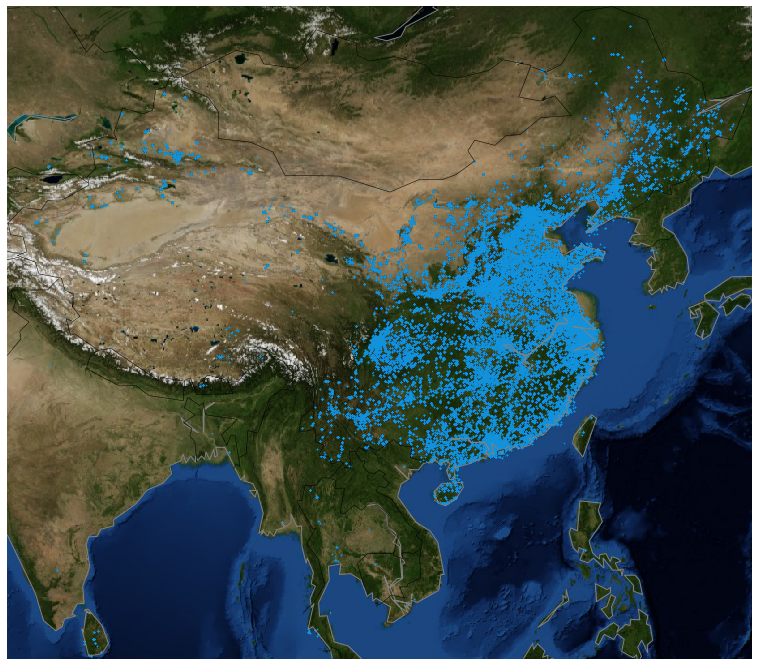

In [6]:
fig = plt.figure(figsize=(16, 10))
m = Basemap(
    projection='mill', lon_0=104.166, lat_0=36.894402,
    llcrnrlon=73.557701, llcrnrlat=5.77539,
    urcrnrlon=134.773605, urcrnrlat=53.5606)
m.bluemarble()
m.drawcoastlines(color = 'gray')
m.drawcountries(color = 'black')
x, y = m(events.longitude.values, events.latitude.values)
m.scatter(x, y, s=1, marker= ',', c="#1292db")

## 1.2 phone brand <a class="anchor" id='phone-brand'></a>
[back to content](#content)

In [7]:
#add english name to phone brand
phone_brand = list(["索尼", "中兴", "金立", "魅族", "华为", "酷派", "小米", "MIL", "PPTV", "ZOYE", "Lovme", "SUGAR", "LOGO", "TCL", "ZUK", "LG", "HTC", "vivo", "OPPO", "E派", "一加", "三星","中国移动","乐视","乡米","优米","优购","努比亚","华硕","唯米","基伍","夏新","大可乐","天语","富可视","小杨树","尼比鲁","德赛","摩乐","摩托罗拉","昂达","易派","普耐尔","朵唯","梦米","欧新","欧比","沃普丰","波导","海信","海尔","爱派尔","神舟","米奇","米歌","糖葫芦","糯米","纽曼","维图","美图","聆韵","联想","艾优尼","西米","语信","诺基亚","谷歌","邦华","酷比魔方","酷珀","锤子","青橙","飞秒","黑米"])
eng_phone_brand = list(["Sony", "ZTE", "gionee", "meizu", "huawei", "coolpad", "MI", "MIL", "PPTV", "ZOYE", "Lovme", "SUGAR", "LOGO", "TCL", "ZUK", "LG", "HTC", "vivo", "OPPO", "epai","oneplus", "samsung", "ccmc", "lshi", "xiangmi", "youmi", "yougo", "nubia", "asus", "weimi", "kiwu", "panosonic", "bigcola", "Ktouch", "fks", "smallt", "nibilu", "desci", "mole", "moto", "ada", "epai", "pner", "dowe", "mengmi", "ouxin", "obi", "wpf", "bodao", "hisense", "haier", "ipair", "hasse", "micky", "mige", "candy", "nuomi", "newman", "weitu", "meitu", "lingyun", "lenovo", "aiyouni", "ximi", "yuxin", "nokia", "google", "banghua", "koobee", "kupo", "hammer", "greeno", "fs", "heymi"])
phone_brand_trans = pd.DataFrame({'phone_brand': phone_brand, 'eng_phone_brand': eng_phone_brand})
phone = phone.merge(phone_brand_trans,how = "left", on = "phone_brand").set_index(phone.index)

#encode brand
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
phone.head(3)

,phone_brand,device_model,eng_phone_brand,brand
device_id,,,,
-8890648629457979026,小米,红米,MI,51
1277779817574759137,小米,MI 2,MI,51
5137427614288105724,三星,Galaxy S4,samsung,15


In [8]:
train_phone = pd.merge(train,phone,how = "left", left_index=True, right_index=True)
test_phone = pd.merge(test,phone,how = "left", left_index=True, right_index=True)
train_phone.head(3)
test_phone.head(3)

,gender,age,group,trainrow,phone_brand,device_model,eng_phone_brand,brand
device_id,,,,,,,,
-8076087639492063270,M,35,M32-38,0,小米,MI 2,MI,51
-2897161552818060146,M,35,M32-38,1,小米,MI 2,MI,51
-8260683887967679142,M,35,M32-38,2,小米,MI 2,MI,51


,testrow,phone_brand,device_model,eng_phone_brand,brand
device_id,,,,,
1002079943728939269,0,小米,小米note,MI,51
-1547860181818787117,1,小米,红米2,MI,51
7374582448058474277,2,华为,Y523-L176,huawei,31


10 most popular brands account for more than 90% of devices. 

(0, 30)

Text(0.5,0,'N most popular brands')

Text(0,0.5,'% of devices')

Text(0.5,1,'10 most popular brands account for more than 90% of devices')

C:\Users\yiqin\Anaconda3\lib\site-packages\seaborn\categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,0,'count of brand')

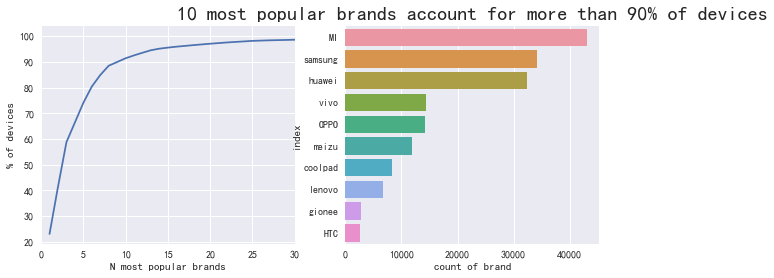

In [9]:
c = phone.brand.value_counts()
s = c.cumsum()/c.sum()
fig, (ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(10,4))
ax1.plot(np.arange(s.shape[0])+1, s.values*100)
ax1.set_xlim(0,30)
ax1.set_xlabel('N most popular brands')
ax1.set_ylabel('% of devices')
plt.title("10 most popular brands account for more than 90% of devices",fontsize = 20)

brand_count = phone["eng_phone_brand"].value_counts().reset_index().head(10)
ax2 = sns.barplot(y = brand_count["index"],x = brand_count["eng_phone_brand"])
ax2.set_xlabel('count of brand')

top 10 phone brand in each group

Median age in top 10 phone brand. User of Samsung, Huawei and lenova are relativly older.

C:\Users\yiqin\Anaconda3\lib\site-packages\seaborn\categorical.py:478: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Median age in top 10 phone brand. User of Samsung, Huawei and lenova are relativly older.')

(0, 60)

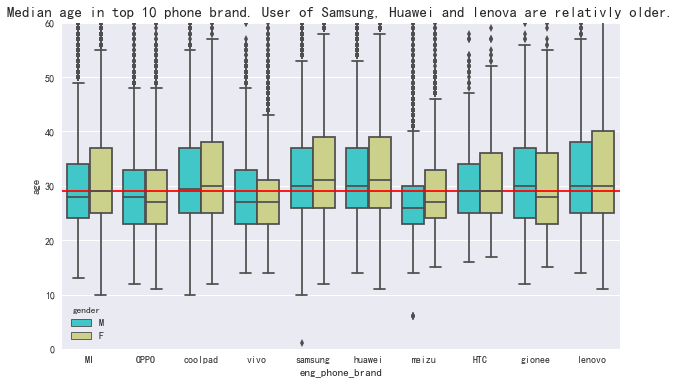

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(x = "eng_phone_brand", y = "age", hue = "gender",palette='rainbow',
            data=train_phone.loc[train_phone["eng_phone_brand"].isin(list(brand_count["index"]))])
plt.axhline(train_phone["age"].median(),color = "red")
plt.title("Median age in top 10 phone brand. User of Samsung, Huawei and lenova are relativly older.", fontsize = 15)
plt.ylim(0,60)

Text(0.5,0,'age')

Text(0,0.5,'percentage')

Text(0.5,1,'Huawei and Samsung have more elder users while Vivo and OPPO have yournger')

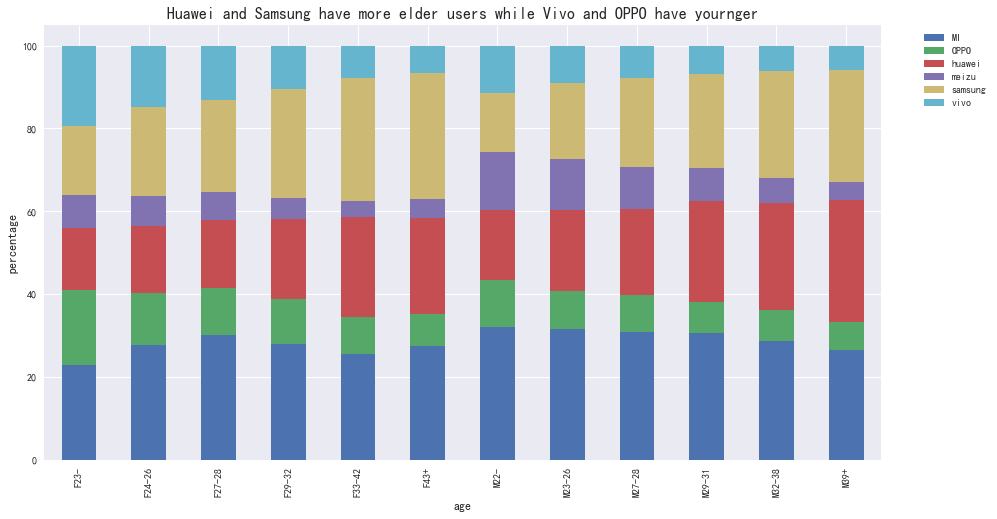

In [11]:
d1 = train_phone.loc[train_phone["eng_phone_brand"].isin(list(brand_count[0:6]["index"]))].groupby(
    ["group","eng_phone_brand"])["age"].count()
d2 = d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
d2.unstack().plot(kind='bar',stacked=True,figsize=(15,8))
plt.xlabel("age",fontsize=12)
plt.ylabel("percentage",fontsize=12)
plt.title("Huawei and Samsung have more elder users while Vivo and OPPO have yournger",fontsize = 16)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

OPPO, Samsung, and Vivo are preffered by female than male

Text(0.5,0,'brand')

Text(0,0.5,'percentage')

Text(0.5,1,'Female user prefer Vivo, OPPO, and Samsung')

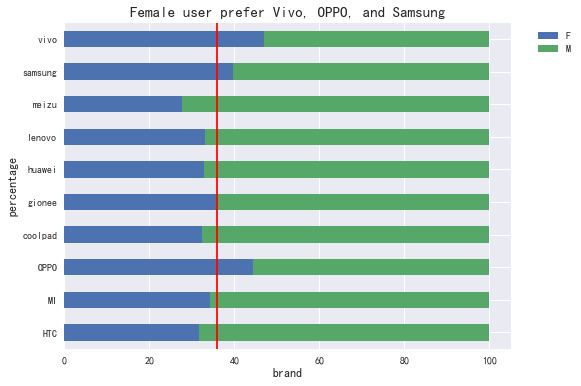

In [12]:
d1 = train_phone.loc[train_phone["eng_phone_brand"].isin(list(brand_count["index"]))].groupby(
    ["eng_phone_brand","gender"])["age"].count()
d2 = d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
d2.unstack().plot(kind='barh',stacked=True,figsize = (8,6))
plt.axvline(d2.unstack()["F"].mean(),color = "red")
plt.xlabel("brand",fontsize = 12)
plt.ylabel("percentage",fontsize = 12)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("Female user prefer Vivo, OPPO, and Samsung", fontsize = 15)

In [13]:
#change the brand that is not in the list of top 10 into 'others'
phone["eng_phone_brand_sub"] = phone["eng_phone_brand"].apply(lambda x: x if x in list(brand_count["index"]) else "Others")
#encode sub brand
subbrandencoder = LabelEncoder().fit(phone.eng_phone_brand_sub)
phone['brand_sub'] = subbrandencoder.transform(phone['eng_phone_brand_sub'])

#merge in to train and test
train_phone = pd.merge(train,phone,how = "left", left_index=True, right_index=True)
test_phone = pd.merge(test,phone,how = "left", left_index=True, right_index=True)
train_phone.head(3)
test_phone.head(3)

,gender,age,group,trainrow,phone_brand,device_model,eng_phone_brand,brand,eng_phone_brand_sub,brand_sub
device_id,,,,,,,,,,
-8076087639492063270,M,35,M32-38,0,小米,MI 2,MI,51,MI,1
-2897161552818060146,M,35,M32-38,1,小米,MI 2,MI,51,MI,1
-8260683887967679142,M,35,M32-38,2,小米,MI 2,MI,51,MI,1


,testrow,phone_brand,device_model,eng_phone_brand,brand,eng_phone_brand_sub,brand_sub
device_id,,,,,,,
1002079943728939269,0,小米,小米note,MI,51,MI,1
-1547860181818787117,1,小米,红米2,MI,51,MI,1
7374582448058474277,2,华为,Y523-L176,huawei,31,huawei,6


Change whole brand data into csr_matrix

In [14]:
Xtr_brand = csr_matrix((np.ones(train_phone.shape[0]), 
                       (train_phone.trainrow, train_phone.brand)))
Xte_brand = csr_matrix((np.ones(test_phone.shape[0]), 
                       (test_phone.testrow, test_phone.brand)))
print('Brand data: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))
Xtr_brand.toarray()

Brand data: train shape (74645, 131), test shape (112071, 131)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

change sub brand data (top 10 and others) into csr_matrix

In [15]:
Xtr_brand_top10 = csr_matrix((np.ones(train_phone.shape[0]), 
                       (train_phone.trainrow, train_phone.brand_sub)))
Xte_brand_top10 = csr_matrix((np.ones(test_phone.shape[0]), 
                       (test_phone.testrow, test_phone.brand_sub)))
print('Brand data: train shape {}, test shape {}'.format(Xtr_brand_top10.shape, Xte_brand_top10.shape))

Brand data: train shape (74645, 11), test shape (112071, 11)


## 1.3 Phone Model <a class="anchor" id='phone-model'></a>
[back to content](#content)

C:\Users\yiqin\Anaconda3\lib\site-packages\seaborn\categorical.py:478: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


(0, 60)

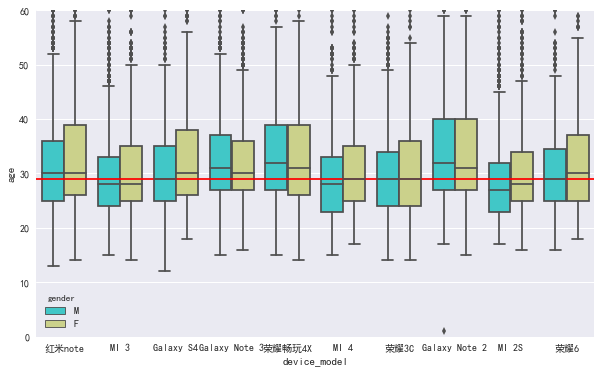

In [16]:
model_count = phone["device_model"].value_counts().reset_index().head(10)
plt.figure(figsize=(10,6))
sns.boxplot(x = "device_model", y = "age", hue = "gender",palette='rainbow',
            data=train_phone.loc[train_phone["device_model"].isin(list(model_count["index"]))])
plt.axhline(train_phone["age"].median(),color = "red")
plt.ylim(0,60)

Text(0.5,0,'age')

Text(0,0.5,'percentage')

Text(0.5,1,'Galaxy Note 3 have more elder users while MI 2S, MI3 and MI4 have yournger')

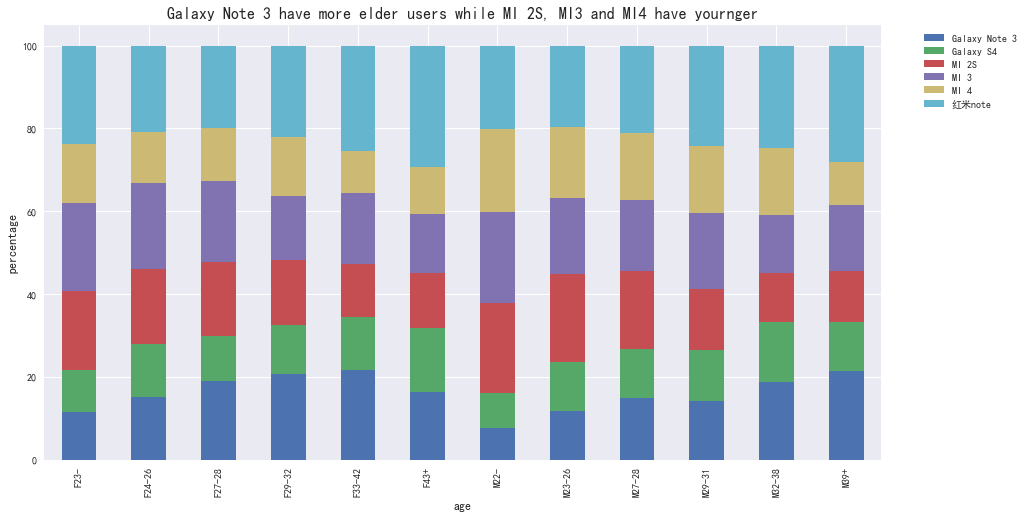

In [17]:
d1 = train_phone.loc[train_phone["device_model"].isin(list(model_count[0:6]["index"]))].groupby(
    ["group","device_model"])["age"].count()
d2 = d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
d2.unstack().plot(kind='bar',stacked=True,figsize=(15,8))
plt.xlabel("age",fontsize=12)
plt.ylabel("percentage",fontsize=12)
plt.title("Galaxy Note 3 have more elder users while MI 2S, MI3 and MI4 have yournger",fontsize = 16)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [18]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
train_phone['model'] = phone['model']
test_phone['model'] = phone['model']

Xtr_model = csr_matrix((np.ones(train_phone.shape[0]), 
                       (train_phone.trainrow, train_phone.model)))
Xte_model = csr_matrix((np.ones(test_phone.shape[0]), 
                       (test_phone.testrow, test_phone.model)))
print('Model data: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model data: train shape (74645, 1667), test shape (112071, 1667)


## 1.4 APP ID  <a class="anchor" id='app-id'></a>
[back to content](#content)

In [19]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(train, how='left', left_index=True, right_index=True)
                       .merge(test, how='left', left_index=True, right_index=True)
                       .reset_index())
"""
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['is_active'].agg(['sum'])
                       .merge(train, how='left', left_index=True, right_index=True)
                       .merge(test, how='left', left_index=True, right_index=True)
                       .reset_index())
"""
deviceapps.head()

"\ndeviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)\n                       .groupby(['device_id','app'])['is_active'].agg(['sum'])\n                       .merge(train, how='left', left_index=True, right_index=True)\n                       .merge(test, how='left', left_index=True, right_index=True)\n                       .reset_index())\n"

,device_id,app,size,gender,age,group,trainrow,testrow
0,-9222956879900151005,548,18,M,36.0,M32-38,21594.0,NaN
1,-9222956879900151005,1096,18,M,36.0,M32-38,21594.0,NaN
2,-9222956879900151005,1248,26,M,36.0,M32-38,21594.0,NaN
3,-9222956879900151005,1545,12,M,36.0,M32-38,21594.0,NaN
4,-9222956879900151005,1664,18,M,36.0,M32-38,21594.0,NaN


In [20]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(train.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(test.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


## 1.5 APP Label  <a class="anchor" id='app-label'></a>
[back to content](#content)

In [25]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)
applabels = applabels.merge(labelcat,on="label_id")
applabels.head(3)

,app_id,label_id,app,label,category_x,category_y,category
0,7324884708820027918,251,17355,207,Finance,Finance,Finance
1,-4494216993218550286,251,4618,207,Finance,Finance,Finance
2,8756705988821000489,251,18741,207,Finance,Finance,Finance


In [26]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label','category']])
                .groupby(['device_id','label','category'])['app'].agg(['size'])
                .merge(train, how='left', left_index=True, right_index=True)
                .merge(test, how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,category,size,gender,age,group,trainrow,testrow
0,-9222956879900151005,117,magazine and journal,1,M,36.0,M32-38,21594.0,NaN
1,-9222956879900151005,120,reading platform,1,M,36.0,M32-38,21594.0,NaN
2,-9222956879900151005,126,news,1,M,36.0,M32-38,21594.0,NaN
3,-9222956879900151005,138,IM,2,M,36.0,M32-38,21594.0,NaN
4,-9222956879900151005,147,map,2,M,36.0,M32-38,21594.0,NaN


Plot the categories that have top and bottom 10 median age and count larger than medium count (enough sample) <br>
APPs realted to vehicles, finance, stock, health, security, heritage etc have older users. <br>
APPs realted to class, game, weibo, animation, Japanness and korean etc have younger user. <br>

C:\Users\yiqin\Anaconda3\lib\site-packages\seaborn\categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


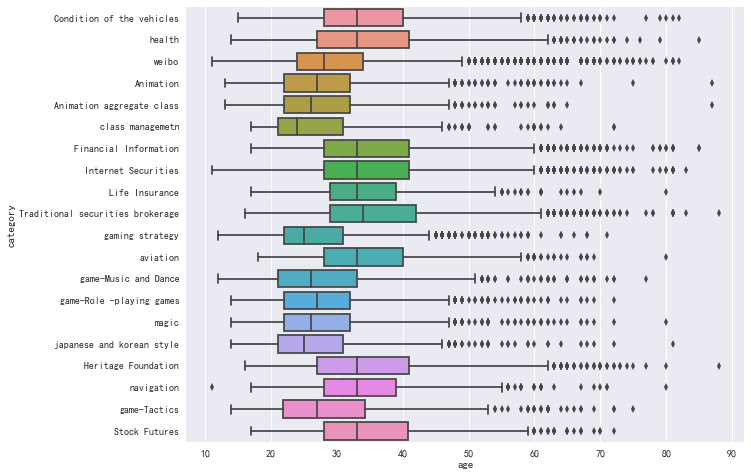

In [27]:
age_by_cat = devicelabels.groupby(["category"])["age"].agg(['median','count']).dropna().\
reset_index().loc[lambda df:df["count"]>df["count"].median()].sort_values(by="median")
age_by_cat = pd.concat([age_by_cat.head(10),age_by_cat.tail(10)])

plt.figure(figsize=(10,8))
sns.boxplot(x = "age", y = "category", \
            data = devicelabels[devicelabels["category"].isin(age_by_cat["category"].values)])

APPS related to health, insureance, animation, music and dance game are preferred by female.<br>
APPS related to vehicle, strategy game, finance, stock, and japannse and korean style are preferred by male.

Text(0,0.5,'category')

Text(0.5,0,'percentage')

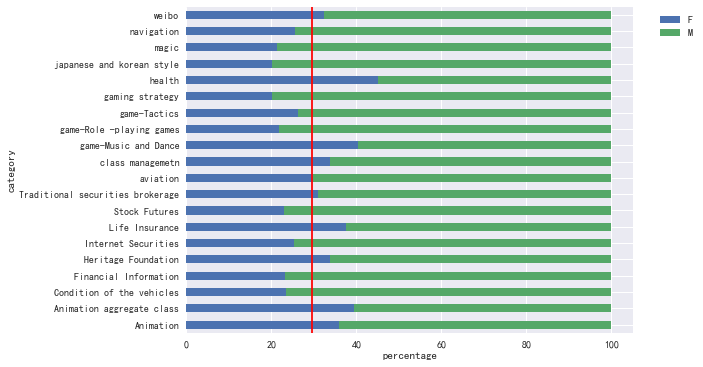

In [28]:
d1 = devicelabels[devicelabels["category"].isin(age_by_cat["category"].values)].groupby(["category","gender"])["age"].count()
d2 = d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
d2.unstack().plot(kind='barh',stacked=True,figsize=(8,6))
plt.axvline(d2.unstack()["F"].mean(),color = "red")
plt.ylabel("category")
plt.xlabel("percentage")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

Text(0.5,0,'group')

Text(0,0.5,'percentage')

Text(0.5,1,'APP Preference acroos Age and Gender')

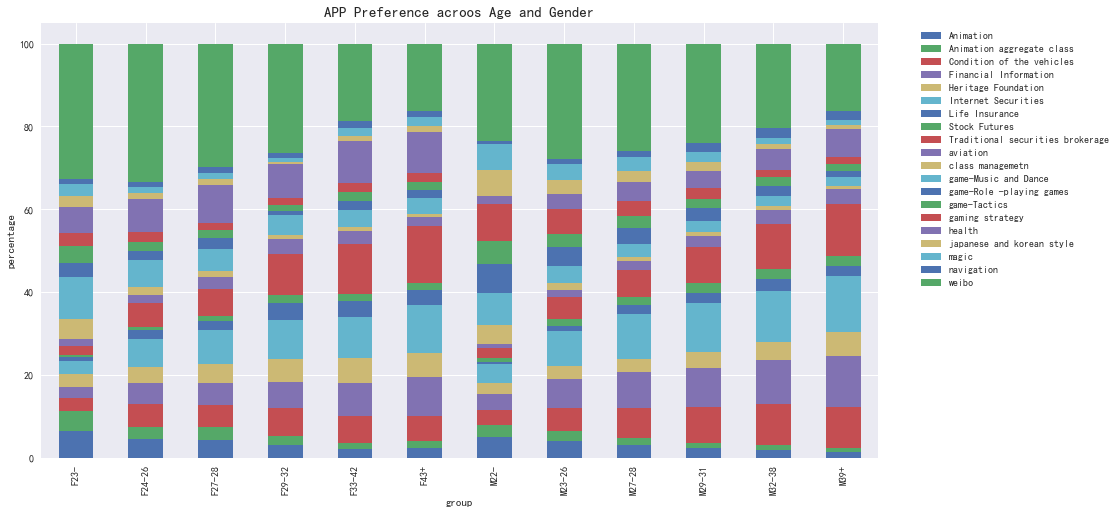

In [29]:
d1 = devicelabels.loc[devicelabels["category"].isin(age_by_cat["category"].values)].groupby(
    ["group","category"])["group"].count()
d2 = d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
d2.unstack().plot(kind='bar',stacked=True,figsize=(15,8))
plt.xlabel("group")
plt.ylabel("percentage")
plt.title("APP Preference acroos Age and Gender",fontsize=15)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

create csr_matrix based on whole app_label data

In [30]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(train.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(test.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 492), test shape (112071, 492)


create csr_matrix based on sub app_label data

In [32]:
#change the category that is not in the list of top and bottom 10 into 'others'
applabels["cat_sub"] = applabels["category"].apply(lambda x: x if x in list(age_by_cat["category"].values) else "Others")
#encode sub category
sublabelencoder = LabelEncoder().fit(applabels.cat_sub)
applabels['label_sub'] = sublabelencoder.transform(applabels.cat_sub)
nlabels = len(sublabelencoder.classes_)
#calculate using label_sub
devicelabels_sub = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label_sub','category']])
                .groupby(['device_id','label_sub','category'])['app'].agg(['size'])
                .merge(train, how='left', left_index=True, right_index=True)
                .merge(test, how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels_sub.head(3)

,device_id,label_sub,category,size,gender,age,group,trainrow,testrow
0,-9222956879900151005,2,Condition of the vehicles,1,M,36.0,M32-38,21594.0,NaN
1,-9222956879900151005,7,1 reputation,1,M,36.0,M32-38,21594.0,NaN
2,-9222956879900151005,7,Accounting,1,M,36.0,M32-38,21594.0,NaN


In [33]:
d = devicelabels_sub.dropna(subset=['trainrow'])
Xtr_label_topbot10 = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label_sub)), 
                      shape=(train.shape[0],nlabels))
d = devicelabels_sub.dropna(subset=['testrow'])
Xte_label_topbot10 = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label_sub)), 
                      shape=(test.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label_topbot10.shape, Xte_label_topbot10.shape))

Labels data: train shape (74645, 21), test shape (112071, 21)


## 1.6 Event trigger time  <a class="anchor" id='event-time'></a>
[back to content](#content)

In [34]:
def binhour(x):
    if x < 5:
        return "midnight"
    elif x < 8:
        return "early morning"
    elif x < 20:
        return "daytime"
    elif x< 23:
        return "night"
    else:
        return "midnight"

In [35]:
events["hour"] = events['timestamp'].apply(lambda x : x.hour)
events["hour2"] = events["hour"].apply(binhour)
events["wkend"] = events["timestamp"].apply(lambda x: 1 if x.dayofweek>4 else 0)
events.head()

,device_id,timestamp,longitude,latitude,hour,hour2,wkend
event_id,,,,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,0,midnight,1
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,0,midnight,1
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,0,midnight,1
4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28,0,midnight,1
5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66,0,midnight,1


In [36]:
eventod = (events.groupby(['device_id','hour2'])['hour2'].agg(['size'])
                       .merge(train, how='left',left_index=True, right_index=True)
                       .merge(test, how='left',left_index=True, right_index=True)
                       .reset_index())
eventod.head()

,device_id,hour2,size,gender,age,group,trainrow,testrow
0,-9222956879900151005,daytime,50,M,36.0,M32-38,21594.0,NaN
1,-9222956879900151005,early morning,2,M,36.0,M32-38,21594.0,NaN
2,-9222956879900151005,midnight,3,M,36.0,M32-38,21594.0,NaN
3,-9222956879900151005,night,10,M,36.0,M32-38,21594.0,NaN
4,-9222661944218806987,daytime,5,NaN,NaN,NaN,NaN,13612.0


Text(0.5,0,'group')

Text(0,0.5,'percentage')

Text(0.5,1,'Younger Users trigger APP more during midnight while elders trigger more during early morning')

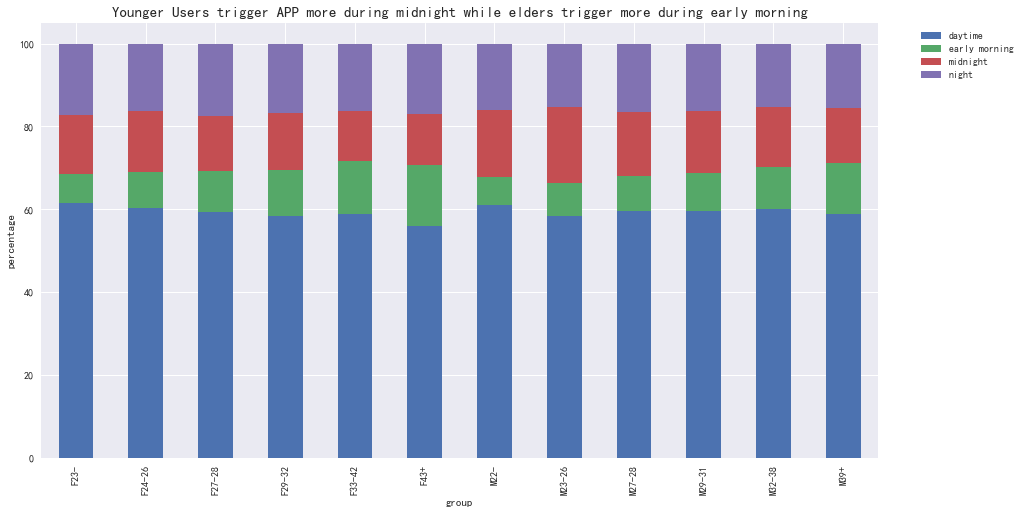

In [37]:
d1 = eventod.groupby(["group","hour2"])["size"].sum()
d2 = d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
d2.unstack().plot(kind='bar',stacked=True,figsize=(15,8))
plt.xlabel("group")
plt.ylabel("percentage")
plt.title("Younger Users trigger APP more during midnight while elders trigger more during early morning",fontsize=15)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [38]:
ntod = 4
todencoder = LabelEncoder().fit(eventod.hour2)
eventod['tod'] = todencoder.transform(eventod['hour2'])
#ls1 = ['midnight','early morning','daytime','night']
#ls2 = [0,1,2,3]
#eventod["tod"] = eventod["hour2"].replace(ls1,ls2)
eventod['size'] = eventod['size'].map(lambda x: np.log(x+1))

t = eventod.dropna(subset=['trainrow'])
Xtr_tod = csr_matrix((t['size'].values, (t.trainrow, t.tod)), 
                      shape=(train.shape[0],ntod))
t = eventod.dropna(subset=['testrow'])
Xte_tod = csr_matrix((t['size'].values, (t.testrow, t.tod)), 
                      shape=(test.shape[0],ntod))
print('TOD data: train shape {}, test shape {}'.format(Xtr_tod.shape, Xte_tod.shape))

TOD data: train shape (74645, 4), test shape (112071, 4)


# 2. Modeling   <a class="anchor" id="model"></a>
[back to content](#content)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import math

C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [40]:
targetencoder = LabelEncoder().fit(train.group)
Ytrain = targetencoder.transform(train.group)
Ytrain
nclasses = len(targetencoder.classes_)
nclasses

array([10, 10, 10, ...,  6, 10,  7], dtype=int64)

12

In [41]:
#Xtrain = hstack((Xtr_brand, Xtr_app, Xtr_label), format='csr')
#Xtest =  hstack((Xte_brand, Xte_app, Xte_label), format='csr')
#Xtrain = hstack((Xtr_brand_top10, Xtr_app, Xtr_label), format='csr')
#Xtest =  hstack((Xte_brand_top10, Xte_app, Xte_label), format='csr')
#Xtr_brand, Xtr_model, Xtr_app, Xtr_label,Xtr_tod,Xtr_brand_top10, Xtr_label_topbot10
#Xte_brand, Xte_model, Xte_app, Xte_label,Xte_tod, Xte_brand_top10, Xte_label_topbot10

Xtrain = hstack((Xtr_brand_top10, Xtr_model, Xtr_app, Xtr_label, Xtr_tod), format='csr')
Xtest =  hstack((Xte_brand_top10, Xte_model, Xte_app, Xte_label, Xte_tod), format='csr')

print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21411), test shape (112071, 21411)


#### 2.0.1Split train into train and test(validation) in stratified way

In [42]:
dtrain_X, dval_X, dtrain_y, dval_y = \
train_test_split(Xtrain, Ytrain, random_state=1026, test_size=0.2,stratify = Ytrain)
print('All features: train shape {}, test shape {}'.format(dtrain_X.shape, dval_X.shape))

All features: train shape (59716, 21411), test shape (14929, 21411)


#### 2.0.2 Prepare a cross validation function to calculate log loss for each model

In [43]:
def cv_los (k,model,Xtrain,Ytrain,**kwargs):
    error = []
    kf = StratifiedKFold(Ytrain, n_folds = k, shuffle=True)
    #loop through K fold
    for i, (train_index, test_index) in enumerate(kf):#get the train and test index generated by Kfold
        x_tr = Xtrain[train_index,:] #xtrain for a fold
        y_tr = Ytrain[train_index] #ytrain for a fold
        x_te = Xtrain[test_index,:]  #xtest for a fold
        y_te = Ytrain[test_index]  #ytest for a fold
        
        #predict and calculate rmsle
        pred_yte = globals()[model](x_tr,y_tr,x_te,**kwargs)
        error.append(log_loss(y_te, pred_yte))
        print("finish {} round of {}, log_loss = {}".format(i,model,log_loss(y_te, pred_yte)))
    return error

## 2.1 Logistic Regression  <a class="anchor" id="logistic"></a>
[back to content](#content)

#### 2.1.1 Find optimal C (smaller values specify stronger regularization) and solver

In [41]:
def eval_logit(train_x,train_y,clf, random_state = 0):
    kf = StratifiedKFold(train_y, n_folds=4, shuffle=True, random_state=random_state)
    pred = np.zeros((train_y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = train_x[itrain, :], train_x[itest, :]
        ytr, yte = train_y[itrain], train_y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    #print('')
    return log_loss(train_y, pred)


def opt_logit_parm(train_x,train_y,random_state = 0, C = 0.02, solver = 'lbfgs', Cs = None, solvers = None):
    #C: smaller values specify stronger regularization
    #solver: ‘newton-cg’, ‘sag’, and ‘lbfgs’
    if list(Cs) and solvers:
        try:
            for solver in solvers:
                res = []
                for C in Cs:
                    clf = LogisticRegression(C = C, multi_class='multinomial', solver=solver)
                    los_score = eval_logit(train_x,train_y,clf,random_state)
                    print("C = {},solver = {}, log_loss = {}".format(C,solver,los_score))
                    res.append(los_score)
                plt.plot(Cs, res,'-o',label = solver)
            plt.legend()
            #plt.xticks(rotation='vertical')
            return 
        except:
            print("error")
            return
              
    try:
        res = []
        for C in Cs:
            print("C = {},solver = {}".format(C,solver))
            clf = LogisticRegression(C = C, multi_class='multinomial', solver=solver)
            res.append(eval_logit(train_x,train_y,clf,random_state))
        plt.semilogx(Cs, res,'-o')
        C = Cs[np.array(res).argmin()] #set C with smallest log_loss when test solver
    except:
        print("no 'C' to be evaluated")
    
    try:
        for solver in solvers:
            print("C = {},solver = {}".format(C,solver))
            clf = LogisticRegression(C = C, multi_class='multinomial', solver=solver)
            los_score = eval_logit(train_x,train_y,clf,random_state)
            print("Solver {} has a log_loss score of {}".format(solver,los_score))
            print("")
    except:
        print("no 'solver' to be evaluated")     

In [ ]:
solvers = ["newton-cg","lbfgs"]
Cs = np.array([0.018,0.019,0.02]) 
opt_logit_parm(Xtrain,Ytrain,Cs = Cs,solvers=solvers)

#### 2.1.2 cross validation 

In [92]:
def logistic_reg(train_x,train_y,test_x,C=0.019,solver = 'newton-cg'):
    clf = LogisticRegression(C=C, multi_class='multinomial',solver=solver)
    clf.fit(train_x, train_y)
    pred = clf.predict_proba(test_x)
    return pred

In [132]:
#check log_loss with cross validation to compare models
k = 5
model = "logistic_reg"
model_params = {
   "C": 0.019,
    "solver": 'newton-cg'
}
error = cv_los(k, model, Xtrain,Ytrain,**model_params)
error
print("The cross validation log_loss of {} is {}".format(model,round(np.mean(error),4)))

finish 0 round of logistic_reg, log_loss = 2.270000992939123
finish 1 round of logistic_reg, log_loss = 2.2700776547146795
finish 2 round of logistic_reg, log_loss = 2.2722834683442854
finish 3 round of logistic_reg, log_loss = 2.278543936172706
finish 4 round of logistic_reg, log_loss = 2.2731293715017897


[2.270000992939123,
 2.2700776547146795,
 2.2722834683442854,
 2.278543936172706,
 2.2731293715017897]

The cross validation log_loss of logistic_reg is 2.2728


#### 2.1.3 Final result for logstic model

In [61]:
pred = logistic_reg(Xtrain,Ytrain,Xtest,**model_params)
pred = pd.DataFrame(pred, index = test.index, columns=targetencoder.classes_)
pred.head()
pred.to_csv('../output/logreg_all.csv',index=True)

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.001906,0.006954,0.015649,0.014361,0.028097,0.046933,0.012915,0.034993,0.081014,0.126865,0.269163,0.361148
-1547860181818787117,0.008491,0.015004,0.032005,0.064298,0.074227,0.149612,0.006309,0.090380,0.055251,0.077753,0.227228,0.199441
7374582448058474277,0.023788,0.038743,0.037928,0.164641,0.164294,0.079544,0.013544,0.026897,0.044241,0.102031,0.179315,0.125032
-6220210354783429585,0.002950,0.027163,0.008192,0.013167,0.050201,0.175586,0.044123,0.135681,0.062825,0.097089,0.175353,0.207670
-5893464122623104785,0.047102,0.065061,0.043151,0.062852,0.056848,0.043292,0.093364,0.164673,0.097449,0.101630,0.132073,0.092505


#### feature importance

In [56]:
clf = LogisticRegression(C=0.019, n_jobs = 2, multi_class='multinomial',solver='newton-cg')
clf.fit(Xtrain,Ytrain)
coef = clf.coef_
coef.shape

LogisticRegression(C=0.019, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

(12, 21527)

In [89]:
def map_feature(n):
    m = n+0
    if m < len(brandencoder.classes_):
        return 'brand {}'.format(brandencoder.classes_[m])
    m -= len(brandencoder.classes_)
    if m < len(modelencoder.classes_):
        return 'model {}'.format(modelencoder.classes_[m])
    m -= len(modelencoder.classes_)
    if m < len(appencoder.classes_):
        return 'app {}'.format(appencoder.classes_[m])
    m -= len(appencoder.classes_)
    return 'label {}'.format(labelcat.loc[labelcat.label_id == labelencoder.classes_[m],"category"].values)

Text(0.5,1,'F23-')

<Container object of 1 artists>

Text(0,-10.6,'brand 三星')

<Container object of 1 artists>

Text(0,10.4,'brand vivo')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,'brand 小米')

<Container object of 1 artists>

Text(0,9.4,'brand 朵唯')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'app -2917998150844653076')

<Container object of 1 artists>

Text(0,8.4,'app -1633913242315646368')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,"label ['Technology Information']")

<Container object of 1 artists>

Text(0,7.4,'brand OPPO')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'app 7460082553072507347')

<Container object of 1 artists>

Text(0,6.4,"label ['foreign language']")

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'brand 华为')

<Container object of 1 artists>

Text(0,5.4,'app 3395900001236628213')

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,'app 7324914609217160422')

<Container object of 1 artists>

Text(0,4.4,'app -6590029937880196169')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,"label ['joke']")

<Container object of 1 artists>

Text(0,3.4,'app -3659463965661490336')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,'model 三星Galaxy Note 2')

<Container object of 1 artists>

Text(0,2.4,'app 7318956472058153296')

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,'model 华为Mate 7')

<Container object of 1 artists>

Text(0,1.4,'app -2320783822570582843')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'F24-26')

<Container object of 1 artists>

Text(0,-10.6,'brand 中兴')

<Container object of 1 artists>

Text(0,10.4,'brand vivo')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,'model 华为Mate 7')

<Container object of 1 artists>

Text(0,9.4,'app 3395900001236628213')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'model OPPOFind 7')

<Container object of 1 artists>

Text(0,8.4,'app 2330237574372846585')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,'app -8678568584846099664')

<Container object of 1 artists>

Text(0,7.4,'app -5924787280098922359')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'model 小米红米1S')

<Container object of 1 artists>

Text(0,6.4,'brand OPPO')

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'app 1088227414300337900')

<Container object of 1 artists>

Text(0,5.4,'app 1183530713303335378')

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,'app -8764672938472212518')

<Container object of 1 artists>

Text(0,4.4,"label ['Trendy / cool 1']")

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,"label ['Stimulate fun']")

<Container object of 1 artists>

Text(0,3.4,'app -5166330690686719214')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,"label ['Car Owners']")

<Container object of 1 artists>

Text(0,2.4,'model 华为Ascend P6')

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,'app -1633933922436094199')

<Container object of 1 artists>

Text(0,1.4,'app -4672998625294552383')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'F27-28')

<Container object of 1 artists>

Text(0,-10.6,'app 1081301425634924658')

<Container object of 1 artists>

Text(0,10.4,'brand vivo')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,"label ['Car Owners']")

<Container object of 1 artists>

Text(0,9.4,'app 628020936226491308')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'app -6172775651801283024')

<Container object of 1 artists>

Text(0,8.4,"label ['Recipes']")

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,"label ['Passion 1']")

<Container object of 1 artists>

Text(0,7.4,'app -5924787280098922359')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'app -2917998150844653076')

<Container object of 1 artists>

Text(0,6.4,'model 三星Galaxy Note 3')

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'app 2353469805335273836')

<Container object of 1 artists>

Text(0,5.4,'model 三星Galaxy Note 2')

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,"label ['Chess categories']")

<Container object of 1 artists>

Text(0,4.4,"label ['pictures photography']")

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,'app 6965654211116534216')

<Container object of 1 artists>

Text(0,3.4,'app 2330237574372846585')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,"label ['Third-party card management']")

<Container object of 1 artists>

Text(0,2.4,'app 1183530713303335378')

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,'app -1633908186354644707')

<Container object of 1 artists>

Text(0,1.4,'app -1405461761481355383')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'F29-32')

<Container object of 1 artists>

Text(0,-10.6,"label ['1 vitality']")

<Container object of 1 artists>

Text(0,10.4,'model 三星Galaxy Note 2')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,'app -5305696816021977482')

<Container object of 1 artists>

Text(0,9.4,"label ['education for babies']")

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'app -6172775651801283024')

<Container object of 1 artists>

Text(0,8.4,"label ['Maternal and child population']")

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,'app -1442117565864503182')

<Container object of 1 artists>

Text(0,7.4,"label ['Pregnant baby']")

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'model 三星Galaxy Win')

<Container object of 1 artists>

Text(0,6.4,'app -4672998625294552383')

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'model 小米红米2')

<Container object of 1 artists>

Text(0,5.4,'brand vivo')

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,'app -1633887856876571208')

<Container object of 1 artists>

Text(0,4.4,'model 三星Galaxy Note 3')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,"label ['gaming strategy']")

<Container object of 1 artists>

Text(0,3.4,"label ['game-pet']")

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,'app -1849893607600785755')

<Container object of 1 artists>

Text(0,2.4,"label ['Accounting']")

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,"label ['game-Role -playing games']")

<Container object of 1 artists>

Text(0,1.4,'brand 三星')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'F33-42')

<Container object of 1 artists>

Text(0,-10.6,'brand 魅族')

<Container object of 1 artists>

Text(0,10.4,"label ['education outside class']")

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,'app -6172775651801283024')

<Container object of 1 artists>

Text(0,9.4,'app 3742278438460437277')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'app -5720078949152207372')

<Container object of 1 artists>

Text(0,8.4,'brand 三星')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,'app -1442117565864503182')

<Container object of 1 artists>

Text(0,7.4,"label ['education for babies']")

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,"label ['Consumer Finance']")

<Container object of 1 artists>

Text(0,6.4,'app 3683147815759994238')

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'app -6689096779184407258')

<Container object of 1 artists>

Text(0,5.4,'app -6295932190539641642')

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,'app 7316250158002095415')

<Container object of 1 artists>

Text(0,4.4,'app 3352730443702988322')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,"label ['Automotive News']")

<Container object of 1 artists>

Text(0,3.4,'app -1659056212576259512')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,"label ['Lottery ticket']")

<Container object of 1 artists>

Text(0,2.4,'app -525778058644348828')

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,'app -649224465541498412')

<Container object of 1 artists>

Text(0,1.4,'app -7062887504622745891')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'F43+')

<Container object of 1 artists>

Text(0,-10.6,'app -5720078949152207372')

<Container object of 1 artists>

Text(0,10.4,"label ['Traditional securities brokerage']")

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,'brand 魅族')

<Container object of 1 artists>

Text(0,9.4,'app 3683147815759994238')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,"label ['Consumer Finance']")

<Container object of 1 artists>

Text(0,8.4,'brand 三星')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,'brand vivo')

<Container object of 1 artists>

Text(0,7.4,'model 三星Galaxy Win')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'app 2353469805335273836')

<Container object of 1 artists>

Text(0,6.4,"label ['Medical']")

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'app -6590029937880196169')

<Container object of 1 artists>

Text(0,5.4,'model 三星Galaxy Note 2')

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,"label ['Pursuit 1']")

<Container object of 1 artists>

Text(0,4.4,'app 5430667454710844136')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,'app -196592189248911642')

<Container object of 1 artists>

Text(0,3.4,'app -5305696816021977482')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,'app 6989638496562408848')

<Container object of 1 artists>

Text(0,2.4,'model 小米红米')

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,"label ['map']")

<Container object of 1 artists>

Text(0,1.4,'app -1562373526021293187')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'M22-')

<Container object of 1 artists>

Text(0,-10.6,'brand 三星')

<Container object of 1 artists>

Text(0,10.4,'app -3659463965661490336')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,"label ['The elimination of class']")

<Container object of 1 artists>

Text(0,9.4,'brand 魅族')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'model 三星Galaxy Note 2')

<Container object of 1 artists>

Text(0,8.4,'app -6172775651801283024')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,'app 3683147815759994238')

<Container object of 1 artists>

Text(0,7.4,'app -1442117565864503182')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'brand 索尼')

<Container object of 1 artists>

Text(0,6.4,'app -8306913357330257467')

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'model 小米MI 2')

<Container object of 1 artists>

Text(0,5.4,'app -5305696816021977482')

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,'brand LG')

<Container object of 1 artists>

Text(0,4.4,'app 5242380966370448942')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,"label ['game-Cartoon']")

<Container object of 1 artists>

Text(0,3.4,'app 7318956472058153296')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,'app 3742278438460437277')

<Container object of 1 artists>

Text(0,2.4,"label ['gaming strategy']")

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,'model 魅族MX2')

<Container object of 1 artists>

Text(0,1.4,'app -4675006368614513044')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'M23-26')

<Container object of 1 artists>

Text(0,-10.6,"label ['education for babies']")

<Container object of 1 artists>

Text(0,10.4,'brand 魅族')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,'model 三星Galaxy Note 2')

<Container object of 1 artists>

Text(0,9.4,'app -1442117565864503182')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'brand 朵唯')

<Container object of 1 artists>

Text(0,8.4,'app -6172775651801283024')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,'app 8146377439288127221')

<Container object of 1 artists>

Text(0,7.4,'app 4317667454960363316')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'brand 三星')

<Container object of 1 artists>

Text(0,6.4,'app -2917998150844653076')

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'app 8693964245073640147')

<Container object of 1 artists>

Text(0,5.4,'model vivoXplay')

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,'app -1633913242315646368')

<Container object of 1 artists>

Text(0,4.4,'app -5720078949152207372')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,'model 小米红米note')

<Container object of 1 artists>

Text(0,3.4,'app -4950143259631681001')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,'app -2633518405377083261')

<Container object of 1 artists>

Text(0,2.4,'model 酷派大神F1')

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,"label ['Business simulation']")

<Container object of 1 artists>

Text(0,1.4,'app 1961990466164001614')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'M27-28')

<Container object of 1 artists>

Text(0,-10.6,"label ['education outside class']")

<Container object of 1 artists>

Text(0,10.4,'brand 魅族')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,"label ['Trendy / cool 1']")

<Container object of 1 artists>

Text(0,9.4,'app -3864848260969172656')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'model 小米红米')

<Container object of 1 artists>

Text(0,8.4,'app -2917998150844653076')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,'app 7318956472058153296')

<Container object of 1 artists>

Text(0,7.4,'model 三星W2014')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'app -1405461761481355383')

<Container object of 1 artists>

Text(0,6.4,"label ['Automotive News']")

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,"label ['pictures photography']")

<Container object of 1 artists>

Text(0,5.4,"label ['Consumer Finance']")

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,'app 6666573792468194779')

<Container object of 1 artists>

Text(0,4.4,'app 1407319030949088160')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,"label ['Business simulation']")

<Container object of 1 artists>

Text(0,3.4,'app -7633370358426043343')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,'model 三星Galaxy Mega 5.8')

<Container object of 1 artists>

Text(0,2.4,"label ['1 vitality']")

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,'app 3352730443702988322')

<Container object of 1 artists>

Text(0,1.4,'app 1961990466164001614')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'M29-31')

<Container object of 1 artists>

Text(0,-10.6,'brand vivo')

<Container object of 1 artists>

Text(0,10.4,'app -5368809411346728624')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,"label ['education outside class']")

<Container object of 1 artists>

Text(0,9.4,'brand LG')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'brand OPPO')

<Container object of 1 artists>

Text(0,8.4,'app 2353469805335273836')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,"label ['foreign language']")

<Container object of 1 artists>

Text(0,7.4,'app 360173083053693637')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'app 7536856914263861653')

<Container object of 1 artists>

Text(0,6.4,'app -3864848260969172656')

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'model 三星Galaxy Win')

<Container object of 1 artists>

Text(0,5.4,'app 7324914609217160422')

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,'app -5924787280098922359')

<Container object of 1 artists>

Text(0,4.4,'app 3039209606161708684')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,'app 8779171476653158532')

<Container object of 1 artists>

Text(0,3.4,'model 三星Galaxy A8')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,'app -1633913242315646368')

<Container object of 1 artists>

Text(0,2.4,'app 5521284031585796822')

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,"label ['Finance']")

<Container object of 1 artists>

Text(0,1.4,'model LGNexus 5')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'M32-38')

<Container object of 1 artists>

Text(0,-10.6,'brand vivo')

<Container object of 1 artists>

Text(0,10.4,'app -5368809411346728624')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,'app -3659463965661490336')

<Container object of 1 artists>

Text(0,9.4,'app 3552207646238057279')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'app 3352730443702988322')

<Container object of 1 artists>

Text(0,8.4,'app 5092210438051004004')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,'brand OPPO')

<Container object of 1 artists>

Text(0,7.4,'app -7062887504622745891')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'app -5924787280098922359')

<Container object of 1 artists>

Text(0,6.4,"label ['Sports News']")

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'app -5305696816021977482')

<Container object of 1 artists>

Text(0,5.4,"label ['education for babies']")

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,"label ['pictures photography']")

<Container object of 1 artists>

Text(0,4.4,'app 8146377439288127221')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,'model 小米MI 2S')

<Container object of 1 artists>

Text(0,3.4,"label ['Lottery ticket']")

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,'app 3395900001236628213')

<Container object of 1 artists>

Text(0,2.4,"label ['Jobs']")

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,'app 2330237574372846585')

<Container object of 1 artists>

Text(0,1.4,'app -4867788435976563864')

(-11, 11)

[Text(0,0,'')]

Text(0.5,1,'M39+')

<Container object of 1 artists>

Text(0,-10.6,'brand 魅族')

<Container object of 1 artists>

Text(0,10.4,'app 6672544982336752002')

(-11, 11)

<Container object of 1 artists>

Text(0,-9.6,'brand vivo')

<Container object of 1 artists>

Text(0,9.4,'app -4532036554977283654')

(-11, 11)

<Container object of 1 artists>

Text(0,-8.6,'app -6590029937880196169')

<Container object of 1 artists>

Text(0,8.4,'model 华为Mate 7')

(-11, 11)

<Container object of 1 artists>

Text(0,-7.6,'brand OPPO')

<Container object of 1 artists>

Text(0,7.4,'app -653191793837778174')

(-11, 11)

<Container object of 1 artists>

Text(0,-6.6,'app -6172775651801283024')

<Container object of 1 artists>

Text(0,6.4,'app -8345186165029874230')

(-11, 11)

<Container object of 1 artists>

Text(0,-5.6,'model 小米MI 4')

<Container object of 1 artists>

Text(0,5.4,"label ['education outside class']")

(-11, 11)

<Container object of 1 artists>

Text(0,-4.6,'app 8573718163932041163')

<Container object of 1 artists>

Text(0,4.4,'app -2633518405377083261')

(-11, 11)

<Container object of 1 artists>

Text(0,-3.6,'app -5924787280098922359')

<Container object of 1 artists>

Text(0,3.4,'app -4085686983594738208')

(-11, 11)

<Container object of 1 artists>

Text(0,-2.6,"label ['takeaway ordering']")

<Container object of 1 artists>

Text(0,2.4,'brand 中兴')

(-11, 11)

<Container object of 1 artists>

Text(0,-1.6,'app -6689096779184407258')

<Container object of 1 artists>

Text(0,1.4,'app 5909705644131785817')

(-11, 11)

[Text(0,0,'')]

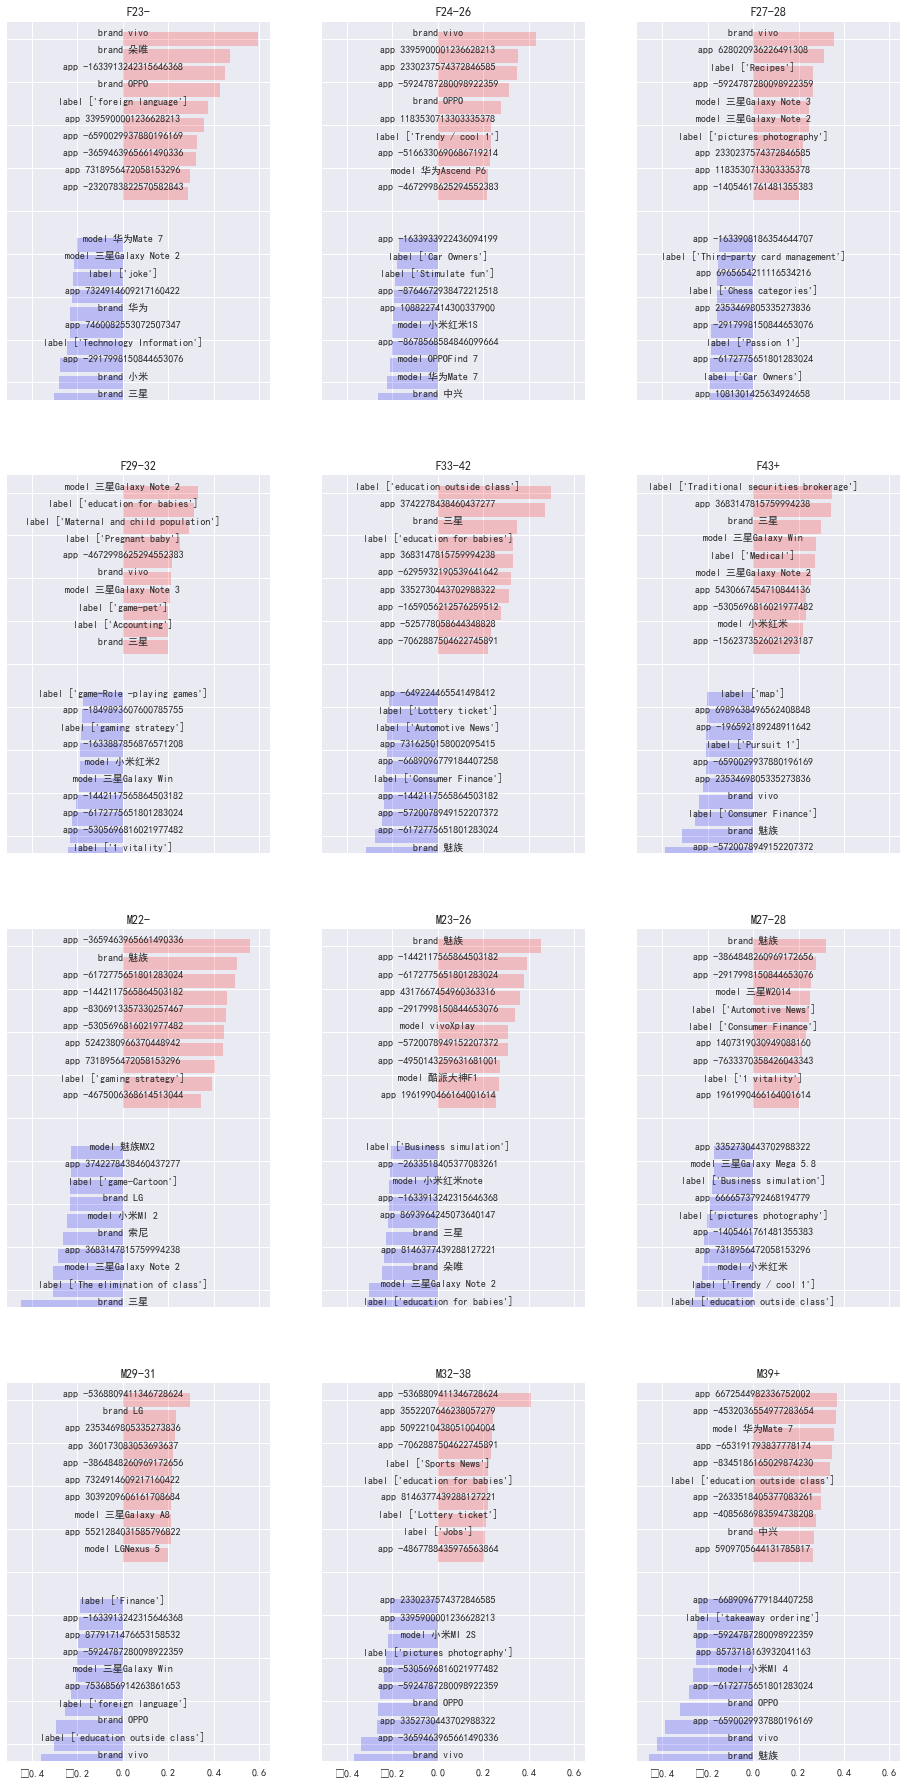

In [90]:
N = 10 # Number of positive and negative traits to plot
fig, ax = plt.subplots(4,3, figsize=(16,32), sharex=True)
ax = ax.flatten()
for i in range(12):
    ax[i].set_title(targetencoder.classes_[i])
    ind = np.argsort(coef[i,:])
    for n in range(N):
        ax[i].barh([-(N-n)-1], [coef[i,ind[n]]], color='b',alpha=0.2)
        ax[i].text(0, -(N-n)-0.6, map_feature(ind[n]),
                   horizontalalignment='center',
                   verticalalignment = 'center')
        ax[i].barh([N-n], [coef[i,ind[-n-1]]], color='r',alpha=0.2)
        ax[i].text(0, N-n+0.4, map_feature(ind[-n-1]),
                   horizontalalignment='center',
                   verticalalignment = 'center')
        ax[i].set_ylim(-N-1,N+1)
    ax[i].set_yticklabels([''])

## 2.2 XGBoost  <a class="anchor" id="xgboost"></a>
[back to content](#content)

In [98]:
import xgboost as xgb

#### 2.2.1 grid search to find optimal parameters

In [100]:
class XGBoostClassifier():
    def __init__(self, num_boost_round=50, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = {label: i for i, label in enumerate(sorted(set(y)))}
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
 
    def predict(self, X):
        num2label = {i: label for label, i in self.label2num.items()}
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
 
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)
 
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
    
def logloss(y_true, Y_pred):
    label2num = dict((name, i) for i, name in enumerate(sorted(set(y_true))))
    return -1 * sum(math.log(y[label2num[label]]) if y[label2num[label]] > 0 else -np.inf for y, label in zip(Y_pred, y_true)) / len(Y_pred)

In [50]:
model = XGBoostClassifier(num_class = nclasses, eval_metric = 'mlogloss')

parameters = {
    'n_estimators': [100],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
     'eta': [0.05],
     'max_depth':range(6,12,2), #default 5, increase this value will make the model more complex / likely to be overfitting
     'min_child_weight':range(1,6,2) #default 1, The larger, the more conservative the algorithm will be
}
grid_obj = GridSearchCV(model, parameters, scoring="neg_log_loss", n_jobs=1, cv=2)
grid_obj = grid_obj.fit(Xtrain, Ytrain)

In [52]:
#grid_obj.grid_scores_
best_parameters, score, _ = max(grid_obj.grid_scores_, key=lambda x: x[1])
best_parameters
score

C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'colsample_bytree': 0.8,
 'eta': 0.05,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.8}

-2.3547578789726455

In [54]:
model = XGBoostClassifier(num_class = nclasses, eval_metric = 'mlogloss')

parameters = {
    'n_estimators': [100],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
     'eta': [0.05],
     'max_depth': [10],
     'min_child_weight':[5],
    'gamma':[0,0.1,0.2] #minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
}

grid_obj = GridSearchCV(model, parameters, scoring="neg_log_loss", n_jobs=1, cv=5)
grid_obj = grid_obj.fit(Xtrain, Ytrain)

In [55]:
#grid_obj.grid_scores_
best_parameters, score, _ = max(grid_obj.grid_scores_, key=lambda x: x[1])
best_parameters
score

C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'colsample_bytree': 0.8,
 'eta': 0.05,
 'gamma': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.8}

-2.3349918974229227

In [56]:
model = XGBoostClassifier(num_class = nclasses, eval_metric = 'mlogloss')

parameters = {
    'n_estimators': [100],
    'subsample': [0.7,0.8,0.9], #0.5 means that XGBoost randomly collected half of the data instances to grow trees and this will prevent overfitting
    'colsample_bytree': [0.7,0.8,0.9], #subsample ratio of columns when constructing each tree
     'eta': [0.05],
     'max_depth': [10],
     'min_child_weight':[5],
    'gamma':[0.1]
}

grid_obj = GridSearchCV(model, parameters, scoring="neg_log_loss", n_jobs=1, cv=5)
grid_obj = grid_obj.fit(Xtrain, Ytrain)

In [57]:
#grid_obj.grid_scores_
best_parameters, score, _ = max(grid_obj.grid_scores_, key=lambda x: x[1])
best_parameters
score

C:\Users\yiqin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'colsample_bytree': 0.9,
 'eta': 0.05,
 'gamma': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.8}

-2.334699416002878

#### 2.2.2 find optimal num of boosting round

In [114]:
def opt_num_boost_round(train_x,train_y,xgb_params):
    dtrain = xgb.DMatrix(train_x, train_y)
    cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=200, early_stopping_rounds=100,
        verbose_eval=20, show_stdv=False)
    cv_output[['train-mlogloss-mean', 'test-mlogloss-mean']].plot()
    
def xgb_model(train_x,train_y,test_x,xgb_params,num_round):
    dtrain = xgb.DMatrix(train_x, train_y)
    xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_round)
    pred = xgb_model.predict(xgb.DMatrix(test_x))
    return pred

In [115]:
xgb_params = {
    'eta': 0.05, 
    'max_depth': 10,
    'min_child_weight': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'gamma': 0.1,
    "booster" : "gbtree", #or 'gblinear'
    'objective': 'multi:softprob',
    'num_class': nclasses,
    'eval_metric': 'mlogloss',
    #'lambda': 3,
    #'alpha': 2,
    'silent': 1
}

#opt_num_boost_round(dtrain_X,dtrain_y,xgb_params)

#### 2.2.3 cross validation

In [135]:
k = 5
model = "xgb_model"
model_params = {
   "xgb_params": xgb_params,
    "num_round": 80
}
error = cv_los(k, model, Xtrain,Ytrain,**model_params)
error
print("The cross validation log_loss of {} is {}".format(model,round(np.mean(error),4)))

finish 0 round of xgb_model, log_loss = 2.302508671847278
finish 1 round of xgb_model, log_loss = 2.309205088485469
finish 2 round of xgb_model, log_loss = 2.3111143021428258
finish 3 round of xgb_model, log_loss = 2.3103397908306267
finish 4 round of xgb_model, log_loss = 2.304154333795734


[2.302508671847278,
 2.309205088485469,
 2.3111143021428258,
 2.3103397908306267,
 2.304154333795734]

The cross validation log_loss of xgb_model is 2.3075


#### 2.2.4 final result 

In [104]:
#xgb_model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
pred = xgb_model(Xtrain,Ytrain,Xtest,xgb_params,80)
pred = pd.DataFrame(pred, index = test.index, columns=targetencoder.classes_)
pred.head()
pred.to_csv('../output/xgb_bestpar_subm.csv',index=True)

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.018839,0.020565,0.026769,0.037865,0.062421,0.035689,0.021592,0.073140,0.068645,0.176849,0.201512,0.256112
-1547860181818787117,0.018238,0.021146,0.026190,0.055849,0.084005,0.110253,0.027681,0.066158,0.054200,0.097298,0.154049,0.284932
7374582448058474277,0.058466,0.062064,0.049336,0.170858,0.091693,0.062860,0.048366,0.039194,0.063742,0.081554,0.121622,0.150245
-6220210354783429585,0.020795,0.041588,0.020692,0.040586,0.088076,0.105034,0.023260,0.107523,0.074993,0.091473,0.172632,0.213348
-5893464122623104785,0.058476,0.061965,0.047432,0.063225,0.069986,0.055490,0.106449,0.136450,0.090031,0.095534,0.119021,0.095939


## 2.3 Random Forest  <a class="anchor" id="randomforest"></a>
[back to content](#content)

In [45]:
from sklearn.ensemble import RandomForestClassifier

#### 2.3.1 grid search best parameters

In [62]:
model = RandomForestClassifier()
parameters = {'n_estimators': [200,300], 
              'max_features': ['log2', 'sqrt','auto'], #The number of features to consider when looking for the best split
              'max_depth': [10, 12, 15], 
              'min_samples_split': [5,7,9],
             }
grid_obj = GridSearchCV(model, parameters, scoring="neg_log_loss",n_jobs=4,cv = 5)
grid_obj = grid_obj.fit(dtrain_X,dtrain_y)
model_params = grid_obj.best_params_
model_params

{'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_split': 9,
 'n_estimators': 300}

In [46]:
model = RandomForestClassifier()
parameters = {'n_estimators': [400,500], 
              'max_features': ['sqrt'], #The number of features to consider when looking for the best split
              'max_depth': [30,50,80], 
              'min_samples_split': [9,15,21],
             }
grid_obj = GridSearchCV(model, parameters, scoring="neg_log_loss",n_jobs=4,cv = 5)
grid_obj = grid_obj.fit(dtrain_X,dtrain_y)
model_params = grid_obj.best_params_
model_params

{'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_split': 9,
 'n_estimators': 500}

In [ ]:
model = RandomForestClassifier()
parameters = {'n_estimators': [500], 
              'max_features': ['sqrt'], #The number of features to consider when looking for the best split
              'max_depth': [100,150], 
              'min_samples_split': [9,11],
             }
grid_obj = GridSearchCV(model, parameters, scoring="neg_log_loss",n_jobs=4,cv = 5)
grid_obj = grid_obj.fit(dtrain_X,dtrain_y)
model_params = grid_obj.best_params_
model_params

#### 2.3.2 cross validation

In [127]:
def random_forest(train_x,train_y,test_x,**kwargs):
    forest = RandomForestClassifier(**kwargs)
    forest.fit(train_x, train_y)
    pred_y = forest.predict_proba(test_x)
    return pred_y

In [126]:
k = 5
model = "random_forest"
error = cv_los(k, model, Xtrain,Ytrain,**model_params)
error
print("The cross validation log_loss of {} is {}".format(model,round(np.mean(error),4)))

finish 0 round of random_forest, log_loss = 2.377920938048484
finish 1 round of random_forest, log_loss = 2.3780258418987423
finish 2 round of random_forest, log_loss = 2.3766270438046693
finish 3 round of random_forest, log_loss = 2.3763786071489323
finish 4 round of random_forest, log_loss = 2.3754610953771347


[2.377920938048484,
 2.3780258418987423,
 2.3766270438046693,
 2.3763786071489323,
 2.3754610953771347]

The cross validation log_loss of random_forest is 2.3769


# Keras

In [42]:
from keras.layers.advanced_activations import PReLU
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD

In [47]:
def batch_generator(X, y, batch_size, shuffle):
    #chenglong code for fiting from generator (https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22567/neural-network-for-sparse-matrices)
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        counter += 1
        yield X_batch
        if (counter == number_of_batches):
            counter = 0
            
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(150, input_dim=dtrain_X.shape[1], init='normal'))
    model.add(PReLU())
    model.add(Dropout(0.4))
    model.add(Dense(50, input_dim=dtrain_X.shape[1], init='normal'))
    model.add(PReLU())
    model.add(Dropout(0.2))
    model.add(Dense(12, init='normal', activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #logloss
    return model

In [ ]:
model=baseline_model()

fit= model.fit_generator(generator=batch_generator(dtrain_X,dtrain_y, 400, True),
                         nb_epoch=16,
                         samples_per_epoch=69984,
                         validation_data=(dval_X.todense(), dval_y), verbose=2
                         )

C:\Users\yiqin\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(150, input_dim=21563, kernel_initializer="normal")`
C:\Users\yiqin\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, input_dim=21563, kernel_initializer="normal")`
C:\Users\yiqin\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="softmax", kernel_initializer="normal")`
C:\Users\yiqin\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
C:\Users\yiqin\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `fit_generator` call to 

Epoch 1/16


# Reference
https://www.kaggle.com/dvasyukova/user-portraits <br>
https://www.kaggle.com/tanitter/grid-search-xgboost-with-scikit-learn <br>
https://www.kaggle.com/poiss0nriot/bag-of-apps-keras-11-08-16-no-val/code <br>